https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset

In [1]:
! pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy  as np
import torch, os
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [2]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
df = pd.read_csv('/content/drive/MyDrive/projects/nnproject/stockdata/stock_data.csv')
df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [4]:
def labelencode(x):
  if x == -1:
    return "negative"
  elif x == 1:
    return "positive"
df['Sentiment'] = df['Sentiment'].apply(labelencode)
df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,positive
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,positive
2,user I'd be afraid to short AMZN - they are lo...,positive
3,MNTA Over 12.00,positive
4,OI Over 21.37,positive
...,...,...
5786,Industry body CII said #discoms are likely to ...,negative
5787,"#Gold prices slip below Rs 46,000 as #investor...",negative
5788,Workers at Bajaj Auto have agreed to a 10% wag...,positive
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",positive


In [5]:
labels = df['Sentiment'].unique()
labels

array(['positive', 'negative'], dtype=object)

In [6]:
NUM_LABELS = len(labels)
id2label = {id:label for id,label in enumerate(labels)}
label2id = {label:id for id,label in enumerate(labels)}

In [7]:
id2label

{0: 'positive', 1: 'negative'}

In [8]:
label2id

{'positive': 0, 'negative': 1}

In [9]:
df['labels'] = df.Sentiment.map(lambda x: label2id[x.strip()])
df

,Text,Sentiment,labels
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,positive,0
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,positive,0
2,user I'd be afraid to short AMZN - they are lo...,positive,0
3,MNTA Over 12.00,positive,0
4,OI Over 21.37,positive,0
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,negative,1
5787,"#Gold prices slip below Rs 46,000 as #investor...",negative,1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,positive,0
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",positive,0


<Axes: ylabel='Sentiment'>

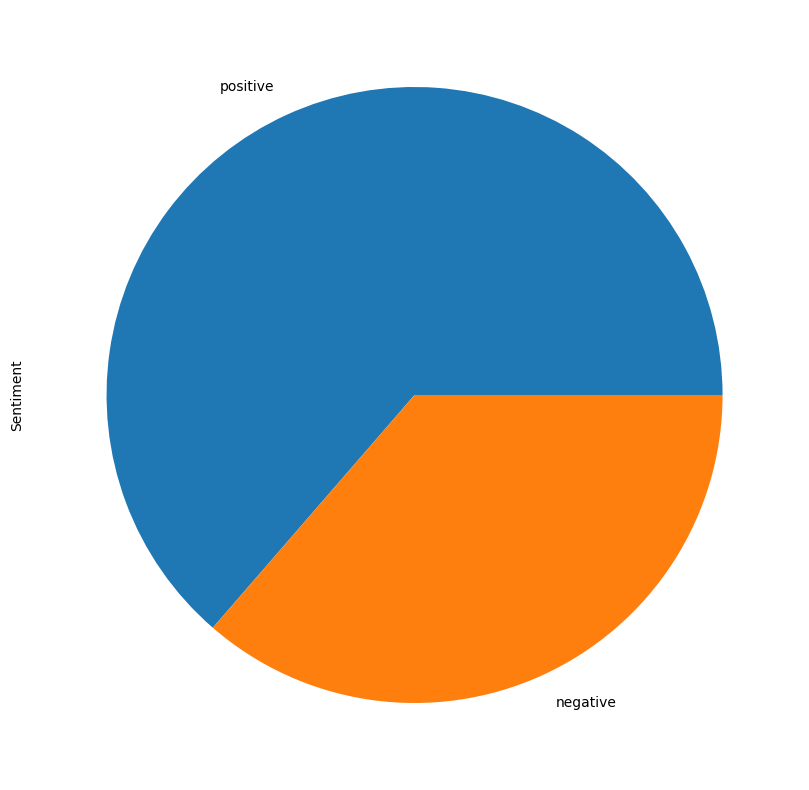

In [10]:
df.Sentiment.value_counts().plot(kind='pie', figsize=(10,10))

In [11]:
tokenizer = BertTokenizerFast.from_pretrained("ProsusAI/finbert",max_length=512)

In [12]:
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df['Text'],df['labels'], test_size=0.1)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1)

In [14]:
X_train = X_train.to_list()
X_test = X_test.to_list()
X_val = X_val.to_list()
y_train = y_train.to_list()
y_test = y_test.to_list()
y_val = y_val.to_list()

In [15]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [16]:
class DataLoader(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels)

In [17]:
train_dataloader = DataLoader(train_encodings, y_train)
test_dataloader = DataLoader(test_encodings, y_test)
val_dataloader = DataLoader(val_encodings, y_val)

In [18]:
from transformers import TrainingArguments, Trainer

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

  acc = accuracy_score(labels, preds)

  return {
      'Accuracy':acc,
      'F1':f1,
      'Precision':precision,
      'Recall':recall
  }

In [21]:
! pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.7 MB/s eta 0:00:00


In [20]:
from transformers import TrainingArguments, Trainer

In [21]:
training_args = TrainingArguments(
    output_dir  = './model1',
    do_train=True,
    do_eval=True,

    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    warmup_steps = 100,
    weight_decay = 0.01,
    logging_strategy = "steps",

    logging_dir="./multi-class-logs",
    logging_steps=50,
    evaluation_strategy = "steps",
    eval_steps=50,
    save_strategy='steps',
    fp16=True,
    load_best_model_at_end=True
)

In [22]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics
)

In [23]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.652800,0.563913,0.718391,0.673799,0.732400,0.671377
100,0.545900,0.495043,0.760536,0.754014,0.751969,0.758190
150,0.485900,0.487262,0.787356,0.779751,0.778459,0.781349
200,0.479000,0.456161,0.770115,0.752297,0.766865,0.746304
250,0.485800,0.417118,0.810345,0.796751,0.810018,0.790185
300,0.408800,0.446537,0.806513,0.804010,0.804060,0.816401
350,0.305100,0.445515,0.791188,0.767379,0.806871,0.757517
400,0.320200,0.484887,0.795019,0.772873,0.808441,0.763097
450,0.333700,0.435770,0.821839,0.811723,0.817708,0.807718
500,0.257300,0.421091,0.814176,0.810043,0.807455,0.817226


TrainOutput(global_step=882, training_loss=0.31142198093353757, metrics={'train_runtime': 110.5292, 'train_samples_per_second': 127.27, 'train_steps_per_second': 7.98, 'total_flos': 404816914222560.0, 'train_loss': 0.31142198093353757, 'epoch': 3.0})

In [24]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.180205,0.936660,0.932871,0.926287,0.942451
val,0.421091,0.814176,0.810043,0.807455,0.817226
test,0.463850,0.781034,0.762257,0.757024,0.770940


In [25]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast


In [26]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [27]:
# Test with a an example text in Turkish
text = "AAPL stock is going to sky rocket to new highs"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.9515, 0.0485]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'positive')

In [28]:
model_path = "tweet-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('tweet-text-classification-model/tokenizer_config.json',
 'tweet-text-classification-model/special_tokens_map.json',
 'tweet-text-classification-model/vocab.txt',
 'tweet-text-classification-model/added_tokens.json',
 'tweet-text-classification-model/tokenizer.json')

Re-Load saved model for inference

In [29]:
model_path = "tweet-text-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [30]:
nlp("AAPL stock is going to sky rocket to new highs")

[{'label': 'positive', 'score': 0.9514352083206177}]

In [33]:
preds = nlp(X_test)

In [36]:
y_pred = []
for i in preds:
  if i['label'] == 'positive':
    y_pred.append(0)
  elif i['label'] == 'negative':
    y_pred.append(1)



In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       384
           1       0.66      0.74      0.70       196

    accuracy                           0.78       580
   macro avg       0.76      0.77      0.76       580
weighted avg       0.79      0.78      0.78       580



[[308  51]
 [ 76 145]]


Text(0.5, 1.0, 'Confusion Matrix: NN')

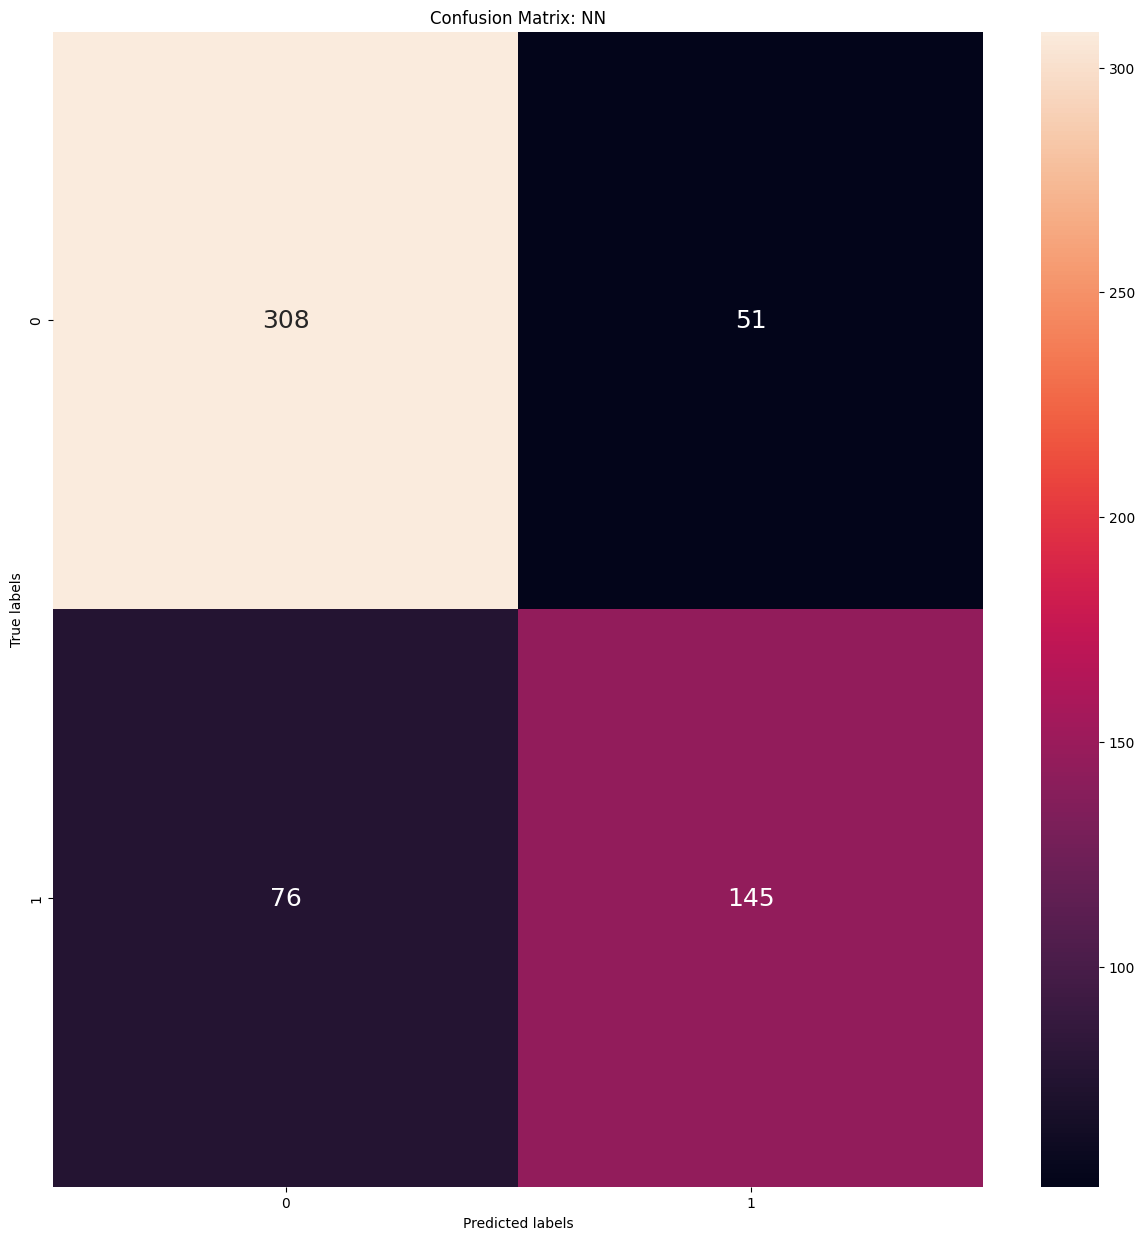

In [40]:
from sklearn.metrics import confusion_matrix

CNN_CM=confusion_matrix(y_pred, y_test)
print(CNN_CM)

#########################################
## Pretty Confusion Matrix........................
#######################################
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(CNN_CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: NN')
# ax.xaxis.set_ticklabels(list(set(y_test)),rotation=90, fontsize = 18)
# ax.yaxis.set_ticklabels(list(set(y_test)),rotation=0, fontsize = 18)